<a href="https://colab.research.google.com/github/Kwamenas/RideHailing-Project/blob/main/EP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ride Hailing

For ride hailing there are two main ways a customer is charged.

1. Upfront Pricing
2. Metered Pricing.

Upfront Pricing: This is the price you see on your phone screen when you are about to  order a ride. This is calculated by the app predicting the distance of customers journey and also predicting the time customer will arrive at his/her destination 

Metered Pricing: this is the actual distance and time customer uses to get to destination

if the metered price based on actual distance and time is 20% more than from the predicted one, the upfront price switches to the metered price

Eg: Customer orders a ride. Customer sees 10 cedis as upfront price.
and the predicted time to destination is 25 mins and predicted distance is 1km.
if upon arival, we realize for customer A  to get to his/her distnation it took more than 25 mins and we covered more than 1 km and our price is 13 cedis, we will switch to 13 cedis and display to customer(Metered Price).

If price is 11 cedi, we will stick to the upfront price





# Goal: To improve upfront price precision and what are the parameters that can help us improve this 

In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame,Series

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
rh_df=pd.read_excel("Ride_Hailing.csv.xlsx",parse_dates=['calc_created'])

In [ ]:
rh_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4943 entries, 0 to 4942
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id_new           4943 non-null   int64         
 1   order_try_id_new       4943 non-null   int64         
 2   calc_created           4943 non-null   datetime64[ns]
 3   metered_price          4923 non-null   float64       
 4   upfront_price          3409 non-null   float64       
 5   distance               4943 non-null   int64         
 6   duration               4943 non-null   int64         
 7   gps_confidence         4943 non-null   int64         
 8   entered_by             4943 non-null   object        
 9   b_state                4943 non-null   object        
 10  dest_change_number     4943 non-null   int64         
 11  prediction_price_type  4923 non-null   object        
 12  predicted_distance     4923 non-null   float64       
 13  pre

In [ ]:
rh_df.isna().sum()

order_id_new                0
order_try_id_new            0
calc_created                0
metered_price              20
upfront_price            1534
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type      20
predicted_distance         20
predicted_duration         20
change_reason_pricing    4645
ticket_id_new               0
device_token             4943
rider_app_version          16
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
eu_indicator                0
overpaid_ride_ticket        0
fraud_score              2759
dtype: int64

Off my head without any calculations the 4 factors that will affect the improvement of upfront price will be 
1. distance
2. duration
3. gps confidence
4. dest change number

Now we can clearly see this is not backed by data so let's see what the data says.

# Missisng Values

First let us deal with the missing values first

1. We are going to delete any metered price which is null and has upfront price as null

Reason: we are assuming customer was charged of the grid hence both were not captured. Our intreset is in upfront price improving so if we have both upfront and metric null then we need to clear it.

So to be sure overpaid_ride_ticket is correct, let's see if there was a customer who had both null and complained about over paid ride



In [ ]:
rh_df[(rh_df['metered_price'].isna()) & (rh_df['upfront_price'].isna()) ]['overpaid_ride_ticket'].value_counts()

0    20
Name: overpaid_ride_ticket, dtype: int64

None of them complained about overpaid_ride_ticket.

Hence overpaid_ride_ticket is ok

In [ ]:
dp_idx=rh_df[(rh_df['metered_price'].isna()) & (rh_df['upfront_price'].isna()) ].index

rh_df=rh_df.drop(index=dp_idx)

In [ ]:
rh_df.isna().sum()

order_id_new                0
order_try_id_new            0
calc_created                0
metered_price               0
upfront_price            1514
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type       0
predicted_distance          0
predicted_duration          0
change_reason_pricing    4625
ticket_id_new               0
device_token             4923
rider_app_version           0
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
eu_indicator                0
overpaid_ride_ticket        0
fraud_score              2741
dtype: int64

In [ ]:
rh_df['prediction_price_type'].isin(['upfront','prediction']).head()

0     True
1     True
2     True
3    False
4     True
Name: prediction_price_type, dtype: bool

So from our Data we realised prediction type can help us know if customer paid using upfront price or metered price.

for those with upfront and prediction option, we can say they are upfront guys.

Now let's see if any of these guys had a complaint on over pricing.

In [ ]:
rh_df[(rh_df['upfront_price'].isna())&(rh_df['prediction_price_type'].isin(['upfront','prediction']))].head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
8,1904,1904,2020-02-20 16:38:34.214,13600.50,NaN,9540,1917,1,client,finished,1,prediction,11018.0,1914.0,NaN,3557,NaN,CA.5.40,finished,finished,DA.4.31,605,TECNO K7,0,0,NaN
15,3638,3638,2020-03-08 21:01:19.427,13643.28,NaN,10365,1533,1,client,finished,1,prediction,9088.0,1175.0,NaN,736,NaN,CI.4.19,finished,finished,DA.4.39,1968,TECNO MOBILE LIMITED TECNO CC7,0,0,NaN
24,1825,1825,2020-02-19 19:05:31.317,12329.22,NaN,8063,1950,1,client,finished,1,prediction,25317.0,3283.0,NaN,3509,NaN,CI.4.17,finished,finished,DA.4.34,587,Samsung SM-T815Y,0,1,NaN
30,2439,2439,2020-02-25 07:40:08.868,14863.50,NaN,9657,2547,0,client,finished,1,prediction,9657.0,1491.0,NaN,4203,NaN,CA.5.44,finished,finished,DA.4.39,2009,INFINIX MOBILITY LIMITED Infinix X606C,0,0,NaN
34,2990,2990,2020-03-01 19:10:46.805,6773.46,NaN,1179,2297,1,client,finished,1,prediction,5530.0,986.0,NaN,4802,NaN,CI.4.17,finished,finished,DA.4.37,1375,INFINIX MOBILITY LIMITED Infinix X5515,0,0,NaN


In [ ]:
rh_df[(rh_df['upfront_price'].isna())&(rh_df['prediction_price_type'].isin(['upfront','prediction']))]['overpaid_ride_ticket'].value_counts()

0    1076
1     226
Name: overpaid_ride_ticket, dtype: int64

So clearly we had customers who had upfront,prediction as their prediction price type but overpaid for the ride.

Which means a customer can over pay for ride despite having an upfront ,predicted price type.

First we will create a column, here we will divide the metric by the predicted.


In [ ]:
rh_df['%of metered_price']=rh_df['metered_price']/rh_df['upfront_price']

The fact that a customer did not complain also doesn't mean there was no overpricing


In [ ]:
rh_df[(rh_df['%of metered_price']>1.2)&(rh_df['overpaid_ride_ticket']==0)].head(2)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score,%of metered_price
1,618,618,2020-02-08 02:26:18.924,6.09,3.6,5698,493,1,client,finished,1,upfront,2286.0,360.0,NaN,2035,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN,1.691667
2,657,657,2020-02-08 11:50:35.423,4.32,3.5,4426,695,1,client,finished,1,upfront,4101.0,433.0,NaN,2222,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0,1.234286


In [ ]:
rh_df[(rh_df['overpaid_ride_ticket']==1)&(rh_df['upfront_price'].isna())]['dest_change_number'].value_counts()

1    218
2     10
5      1
Name: dest_change_number, dtype: int64

In [ ]:
rh_df[(rh_df['overpaid_ride_ticket']==1)&(rh_df['%of metered_price']<1.2)]

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score,%of metered_price
23,1477,1477,2020-02-15 19:41:46.684,6000.00,10000.0,2478,372,1,client,finished,1,upfront,7381.0,934.0,NaN,2998,NaN,CA.5.44,finished,finished,DA.4.37,267,TECNO CA6S,0,1,NaN,0.600000
122,1058,1058,2020-02-12 08:56:25.377,6000.00,6000.0,2362,337,1,client,finished,1,upfront,3551.0,585.0,NaN,2537,NaN,CA.5.43,finished,finished,DA.4.39,1576,TECNO MOBILE LIMITED TECNO BA2,0,1,NaN,1.000000
198,148,148,2020-02-03 11:04:09.319,27435.60,74500.0,12124,3335,0,client,finished,3,upfront,38107.0,2694.0,client_destination_changed,1510,NaN,CI.4.17,finished,finished,DA.4.14,168,TECNO MOBILE LIMITED TECNO KC6,0,1,NaN,0.368263
261,845,845,2020-02-10 02:28:12.862,8650.16,15500.0,5795,624,1,client,finished,1,upfront,11685.0,1244.0,NaN,2284,NaN,CI.4.17,finished,finished,DA.4.37,1325,TECNO MOBILE LIMITED TECNO B1p,0,1,NaN,0.558075
264,1568,1568,2020-02-16 19:02:26.174,6000.00,101500.0,3389,557,1,client,finished,2,upfront,33912.0,3314.0,client_destination_changed,3118,NaN,CA.5.44,finished,finished,DA.4.34,494,TECNO MOBILE LIMITED TECNO KB8,0,1,NaN,0.059113
298,1516,1516,2020-02-16 02:20:50.486,9407.28,9500.0,7133,813,1,client,finished,1,upfront,7043.0,866.0,NaN,3346,NaN,CA.4.83,finished,finished,DA.4.39,1403,TECNO MOBILE LIMITED TECNO KA7,0,1,NaN,0.990240
808,785,785,2020-02-09 12:23:34.233,11097.48,12500.0,7049,1774,1,client,finished,1,upfront,9553.0,1434.0,NaN,2212,NaN,CA.5.38,finished,finished,DA.4.39,1722,TECNO AX8,0,1,NaN,0.887798
850,574,574,2020-02-07 20:47:16.596,90446.78,91500.0,28561,2046,1,client,finished,1,upfront,28670.0,2471.0,NaN,4240,NaN,CI.4.17,finished,finished,DA.4.37,1286,Samsung SM-G955U,0,1,NaN,0.988489
861,401,401,2020-02-06 06:17:13.826,22650.14,20500.0,7577,1344,0,client,finished,1,upfront,6670.0,1263.0,NaN,1813,NaN,CA.5.40,finished,finished,DA.4.37,610,Samsung SM-G531H,0,1,NaN,1.104885
971,642,642,2020-02-08 10:39:13.973,14660.52,16000.0,8295,3104,0,client,finished,1,upfront,12273.0,1899.0,NaN,2251,NaN,CA.5.13,finished,finished,DA.4.23,1127,TECNO F3,0,1,NaN,0.916282


1. Let's see all who said they were overcharged
2. Let's see if there is anyone who had over 1.2%
3. Let's check their average


In [ ]:
rh_df[rh_df['overpaid_ride_ticket']==1].head(2)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score,%of metered_price
3,313,313,2020-02-05 06:34:53.782,72871.72,NaN,49748,1400,0,client,finished,2,upfront_destination_changed,3017.0,600.0,client_destination_changed,1788,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN,NaN
20,201,201,2020-02-03 21:46:30.178,18929.92,6500.0,14560,1421,0,client,finished,1,upfront,3789.0,538.0,NaN,1621,NaN,CA.4.99,finished,finished,DA.4.10,17,TECNO MOBILE LIMITED TECNO B1p,0,1,NaN,2.912295


In [ ]:
rh_df[(rh_df['overpaid_ride_ticket']==1)]['prediction_price_type'].unique()

array(['upfront_destination_changed', 'upfront', 'prediction'],
      dtype=object)

In [ ]:
rh_df[(rh_df['overpaid_ride_ticket']==1)&(rh_df['%of metered_price']<1.2)]['prediction_price_type'].unique()

array(['upfront'], dtype=object)

We have confirmed that most people who had complained of overpaid_ride_ticket and had 20% or less of the metered price , had only upfront price as their price prediction type.

So we will find the average %of metered price and fill 
all those who fall in the above category but have null upfront price

Assumption: So if customer complains of overpricing, then we will assume his upfront price was less.

In [ ]:
avg_perc_up=round(rh_df[(rh_df['overpaid_ride_ticket']==1)&(rh_df['%of metered_price']<1.2)]['%of metered_price'].mean(),2)

In [ ]:
rh_df.loc[(rh_df['upfront_price'].isna())&(rh_df['overpaid_ride_ticket']==1),'upfront_price']=rh_df[(rh_df['upfront_price'].isna())&(rh_df['overpaid_ride_ticket']==1)]['metered_price']*avg_perc_up


#(rh_df['upfront_price'].isna())&(rh_df['prediction_price_type'].isin(['upfront','prediction']))

Assumption: So we need to fill the missing vales for upfront price column. We could have just imagined it was the same as metered price and go with metered price.
but we also need to be aware that before our system will choose metered price, the upfront price must be more than 20% of the metered
 price.

So we decided let's see the average percentage of metered price for customers that had a price display upfront.

then with that, we multiply by the average by the metered price and we can fill those missing values


In [ ]:
avg_perc=round(rh_df[(rh_df['prediction_price_type'].isin(['upfront','prediction']))&(rh_df['upfront_price'].notnull())]['%of metered_price'].mean(),2)

In [ ]:
#avg_perc=round(rh_df[rh_df['prediction_price_type'].isin(['upfront','prediction'])]['%of metered_price'].mean(),2)

In [ ]:
avg_perc

1.19

In [ ]:
rh_df[(rh_df['upfront_price'].isna())&(rh_df['prediction_price_type'].isin(['upfront','prediction']))]['metered_price'].head()

8     13600.50
15    13643.28
30    14863.50
34     6773.46
38    17620.26
Name: metered_price, dtype: float64

In [ ]:
rh_df[(rh_df['upfront_price'].isna())&(rh_df['prediction_price_type'].isin(['upfront','prediction']))]['metered_price']*avg_perc

8        16184.5950
15       16235.5032
30       17687.5650
34        8060.4174
38       20968.1094
41       16480.3338
42       21839.4750
44        7140.0000
46       24378.6018
58       14948.8038
60       13096.5450
61       19714.1112
62        7140.0000
63        8379.7182
77       23854.7400
81        7140.0000
96        7140.0000
98       18127.5318
99       17999.0118
116       7140.0000
117      12654.7932
118       7140.0000
129      41734.7518
132      26083.0626
134       2949.2960
138      20434.1088
139       2380.0000
140      38141.6182
141      28858.9994
142      74225.1076
154       9202.8174
157       7140.0000
158       7140.0000
159      26210.2974
162       7140.0000
167       8719.1538
169      10100.6724
173      39213.7606
174       9274.1460
175       4502.0080
177      15823.0968
181       8503.4544
183      12714.2694
184      15887.6424
185       7140.0000
186      17233.0326
192       6002.7170
195      15043.4088
206      11389.7994
207      35474.8044


In [ ]:
rh_df.loc[(rh_df['upfront_price'].isna())&(rh_df['prediction_price_type'].isin(['upfront','prediction'])),'upfront_price']=rh_df[(rh_df['upfront_price'].isna())&(rh_df['prediction_price_type'].isin(['upfront','prediction']))]['metered_price']*avg_perc

In [ ]:
rh_df.isna().sum()

order_id_new                0
order_try_id_new            0
calc_created                0
metered_price               0
upfront_price             209
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type       0
predicted_distance          0
predicted_duration          0
change_reason_pricing    4625
ticket_id_new               0
device_token             4923
rider_app_version           0
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
eu_indicator                0
overpaid_ride_ticket        0
fraud_score              2741
%of metered_price        1514
dtype: int64

Assumption 2: 

So we assumped that if prediction_price_type was not upfront or predicted then this was not the price customer saw when customer ordered ride, so we decided to make all those values other than upfront or predicted, metered.

to calculate the upfront price for those who had NA,

we decided let's see %of metered price which are over 20%(1.2),
Then we decided we want the average of those ones.

With the average, we decided to divide that by the metered price we have to get the upfront price.

Note our upfront price should be less and our metered price should be more.

In [ ]:
rh_df[rh_df['upfront_price'].isna()]['prediction_price_type'].unique()

array(['upfront_destination_changed', 'upfront_waypoint_changed'],
      dtype=object)

In [ ]:
average_metered=round(rh_df[rh_df['%of metered_price']>=1.21]['%of metered_price'].mean(),2)

In [ ]:
average_metered

1.68

In [ ]:
rh_df[rh_df['prediction_price_type'].isin(['upfront_destination_changed','upfront_waypoint_changed'])].shape

(212, 27)

In [ ]:
#rh_df[(rh_df['upfront_price'].isna())]['metered_price']*average_metered

In [ ]:
rh_df.loc[(rh_df['upfront_price'].isna()),'upfront_price']=rh_df[(rh_df['upfront_price'].isna())]['metered_price']/average_metered

Now we have some upfront price to be null, but these prices have a prediction_price_type to be 

['upfront_destination_changed', 'upfront_waypoint_changed']

This means our system opted for meter price as the price.

So we go ahead and use our metered price as the same price for  upfront price in this criteria.


Now we need to check if there is any meterwed price that is null


In [ ]:
rh_df['%of metered_price']=rh_df['metered_price']/rh_df['upfront_price']

In [ ]:
rh_df.isna().sum()

order_id_new                0
order_try_id_new            0
calc_created                0
metered_price               0
upfront_price               0
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type       0
predicted_distance          0
predicted_duration          0
change_reason_pricing    4625
ticket_id_new               0
device_token             4923
rider_app_version           0
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
eu_indicator                0
overpaid_ride_ticket        0
fraud_score              2741
%of metered_price           0
dtype: int64

●	change_reason_pricing - indicates whose action triggered a change in the price prediction. If it is empty, it means that either nobody changed the destination or that the change has not affected the predicted price

So we will set it to 0 so we can do our analysis based on it 

In [ ]:
rh_df['change_reason_pricing'].unique()

array([nan, 'client_destination_changed', 'driver_destination_changed',
       'driver_waypoint_changed'], dtype=object)

In [ ]:
rh_df['change_reason_pricing'].fillna('No Change',inplace=True)

Let's drop device token as we will not need it 

In [ ]:
rh_df=rh_df.drop(['device_token'],axis=1)


In [ ]:
rh_df.isna().sum()

order_id_new                0
order_try_id_new            0
calc_created                0
metered_price               0
upfront_price               0
distance                    0
duration                    0
gps_confidence              0
entered_by                  0
b_state                     0
dest_change_number          0
prediction_price_type       0
predicted_distance          0
predicted_duration          0
change_reason_pricing       0
ticket_id_new               0
rider_app_version           0
order_state                 0
order_try_state             0
driver_app_version          0
driver_device_uid_new       0
device_name                 0
eu_indicator                0
overpaid_ride_ticket        0
fraud_score              2741
%of metered_price           0
dtype: int64

We decided to fill the fraud score with 0

Now its time for EDA


In [ ]:
rh_df['fraud_score'].fillna(rh_df['fraud_score'].mode()[0],inplace=True)

EDA

Now we are going to explore our data. We will ask some questions then we will go ahead and plot some exploratory and explanatory graphs.



In [ ]:
rh_df.head(2)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score,%of metered_price
0,22,22,2020-02-02 03:37:30.573,4.04,10.0,2839,700,1,client,finished,1,upfront,13384.0,1091.0,No Change,1376,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0,0.404000
1,618,618,2020-02-08 02:26:18.924,6.09,3.6,5698,493,1,client,finished,1,upfront,2286.0,360.0,No Change,2035,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,0.0,1.691667


1. how many rides was completed.
2. How many was cancelled
3. Do we have particular days rides were cancelled
4. Does Fraud score has relationship with the prediction type.
5. Prediction Type and how many are they
6. GPS confidence


First we will have to get the date into Days,Month and Year.

In [ ]:
rh_df['Day_Name']=rh_df['calc_created'].dt.day_name()

So the year is only 2022

Order state is same as b_state

In [ ]:
rh_df=rh_df.drop(['order_state'],axis=1)



All Rides were completed 100%

In [ ]:
rh_df['Day_Name'].unique()

array(['Sunday', 'Saturday', 'Wednesday', 'Thursday', 'Friday', 'Monday',
       'Tuesday'], dtype=object)

In [ ]:
Days=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

#rh_df['Day_Name']=pd.Categorical(rh_df['Day_Name'],categories=Days,ordered=True)

#plt.figure(figsize=(12,8))
#sns.countplot(data=rh_df,x='Day_Name')
#plt.show()
px.histogram(rh_df,x='Day_Name',category_orders=dict(Day_Name=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']))


Friday has the highest day with orders, now we will see if Friday has more upfront price or metered price 

Also we can check when do people with high fraud score work 

So now let's look at the fraud score if we can put them into Fraud /No Fraud..

And see if they affect ride orders and also compare with the prediction type

In [ ]:
Days=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

px.histogram(rh_df,x='Day_Name',category_orders=dict(Day_Name=Days),color='prediction_price_type')


In [ ]:
rh_df['fraud_score']=rh_df['fraud_score'].abs()

In [ ]:
def fraud(row):
  if row > 0:
    return "Fraud"
  else:
    return "No Fraud"

rh_df['Fraud /No Fraud']=rh_df['fraud_score'].apply(fraud)

Since we have the Fraud/No Fraud column we can go ahead and drop the fraud score 

In [ ]:
rh_df=rh_df.drop(['fraud_score'],axis=1)

In [ ]:
rh_df.head(2)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,rider_app_version,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,%of metered_price,Day_Name,Fraud /No Fraud
0,22,22,2020-02-02 03:37:30.573,4.04,10.0,2839,700,1,client,finished,1,upfront,13384.0,1091.0,No Change,1376,CI.4.17,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,0.404000,Sunday,Fraud
1,618,618,2020-02-08 02:26:18.924,6.09,3.6,5698,493,1,client,finished,1,upfront,2286.0,360.0,No Change,2035,CA.5.43,finished,DA.4.39,1578,Samsung SM-G965F,1,0,1.691667,Saturday,No Fraud


Good now we can go ahead and check if fraud and the prediction type has some relationship


In [ ]:
Days=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

px.histogram(rh_df,x='Day_Name',category_orders=dict(Day_Name=Days),color='Fraud /No Fraud')

On Sundays, less fraud suspects work, eventhough it's the secind day with more orders. Friday has about 450 fraud suspect out of over 900 drivers

In [ ]:
rh_df.head(2)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,rider_app_version,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,%of metered_price,Day_Name,Fraud /No Fraud
0,22,22,2020-02-02 03:37:30.573,4.04,10.0,2839,700,1,client,finished,1,upfront,13384.0,1091.0,No Change,1376,CI.4.17,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,0.404000,Sunday,Fraud
1,618,618,2020-02-08 02:26:18.924,6.09,3.6,5698,493,1,client,finished,1,upfront,2286.0,360.0,No Change,2035,CA.5.43,finished,DA.4.39,1578,Samsung SM-G965F,1,0,1.691667,Saturday,No Fraud


<Axes: xlabel='Fraud /No Fraud', ylabel='count'>

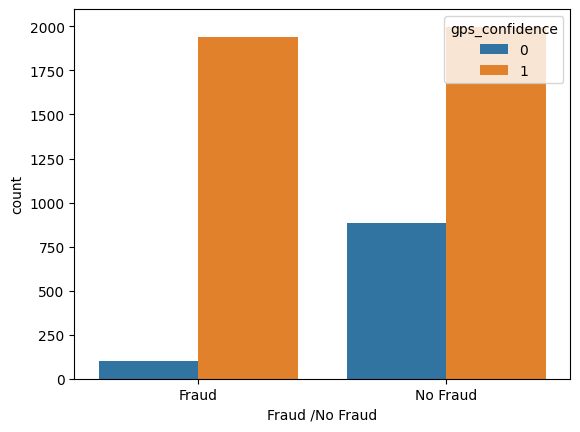

In [ ]:
sns.countplot(data=rh_df,x='Fraud /No Fraud',hue='gps_confidence')

In [ ]:
rh_df['gps_confidence'].value_counts(normalize=True)*100

1    80.032501
0    19.967499
Name: gps_confidence, dtype: float64

80% of riders had confident GPS. 

One more feature engineering. So even tho we have "prediction_price_type" we want to create another column.
This will tell us if customer paid upfront price or metered price.

And we know customer pays metered price if metered price is 20% more than upfront price

In [ ]:
def status(row):
  if row > 1.2:
    return "Metered"
  else:
    return "Upfront"

rh_df['Payment Type']=rh_df['%of metered_price'].apply(status)

In [ ]:
rh_df.head(2)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,rider_app_version,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,%of metered_price,Day_Name,Fraud /No Fraud,Payment Type
0,22,22,2020-02-02 03:37:30.573,4.04,10.0,2839,700,1,client,finished,1,upfront,13384.0,1091.0,No Change,1376,CI.4.17,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,0.404000,Sunday,Fraud,Upfront
1,618,618,2020-02-08 02:26:18.924,6.09,3.6,5698,493,1,client,finished,1,upfront,2286.0,360.0,No Change,2035,CA.5.43,finished,DA.4.39,1578,Samsung SM-G965F,1,0,1.691667,Saturday,No Fraud,Metered


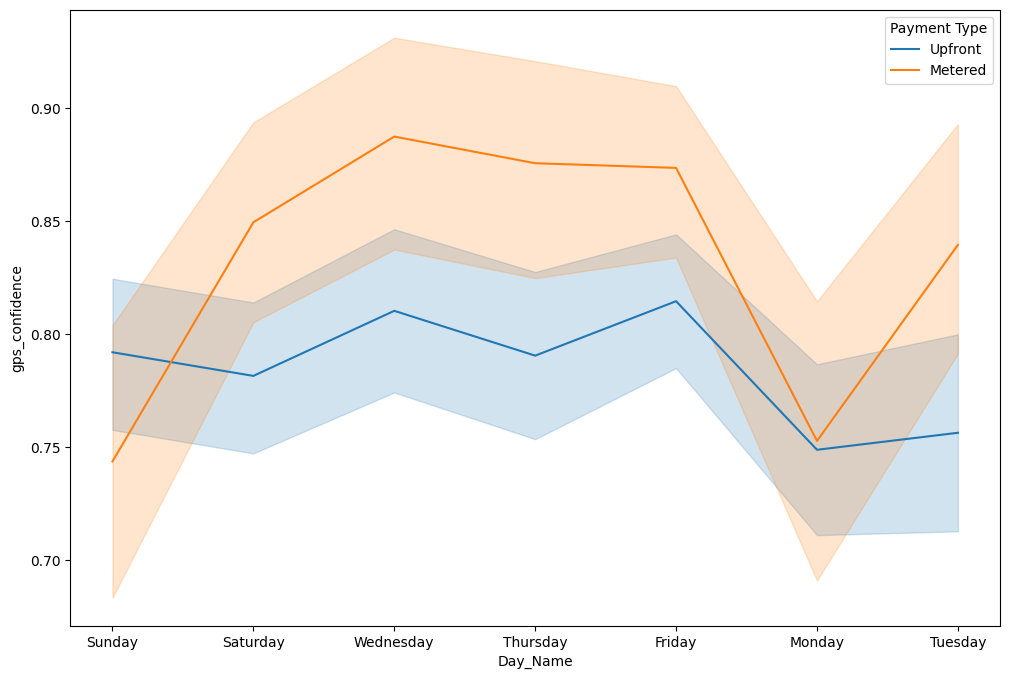

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=rh_df,y='gps_confidence',x='Day_Name',hue='Payment Type')
plt.show()

1. How many payed Metered Price
2. How many payed Upfront Price


In [ ]:
rh_df['Payment Type'].value_counts(normalize=True)*100

Upfront    71.480804
Metered    28.519196
Name: Payment Type, dtype: float64

75% of our customers paid upfront price and 28% paid Metered price.



In [ ]:
rh_df_upfront=rh_df[rh_df['Payment Type']=='Upfront']
rh_df_metered=rh_df[rh_df['Payment Type']=='Metered']

In [ ]:
rh_df_upfront.head(2)

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,dest_change_number,prediction_price_type,predicted_distance,predicted_duration,change_reason_pricing,ticket_id_new,rider_app_version,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,%of metered_price,Day_Name,Fraud /No Fraud,Payment Type
0,22,22,2020-02-02 03:37:30.573,4.04,10.0000,2839,700,1,client,finished,1,upfront,13384.0,1091.0,No Change,1376,CI.4.17,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,0.404000,Sunday,Fraud,Upfront
3,313,313,2020-02-05 06:34:53.782,72871.72,62669.6792,49748,1400,0,client,finished,2,upfront_destination_changed,3017.0,600.0,client_destination_changed,1788,CA.5.23,finished,DA.4.37,1587,TECNO-Y6,0,1,1.162791,Wednesday,No Fraud,Upfront


In [ ]:
rh_df_upfront

Days=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

px.histogram(rh_df_upfront,x='Day_Name',category_orders=dict(Day_Name=Days),color='prediction_price_type')

In [ ]:
rh_df_upfront[['Fraud /No Fraud','gps_confidence']].value_counts(normalize=True)*100

Fraud /No Fraud  gps_confidence
No Fraud         1                 46.121057
Fraud            1                 32.594487
No Fraud         0                 19.636260
Fraud            0                  1.648196
dtype: float64

32% of customers who paid via upfront book drivers who had a high fraud score and had good gps connection,
Also about 47% of the customers had good gps confidence and the drivers had no/low fraud score.

Only 1% of the drivers booked by customers who paid via upfront had high fraud score and low gps confidence.


<Axes: xlabel='Fraud /No Fraud', ylabel='count'>

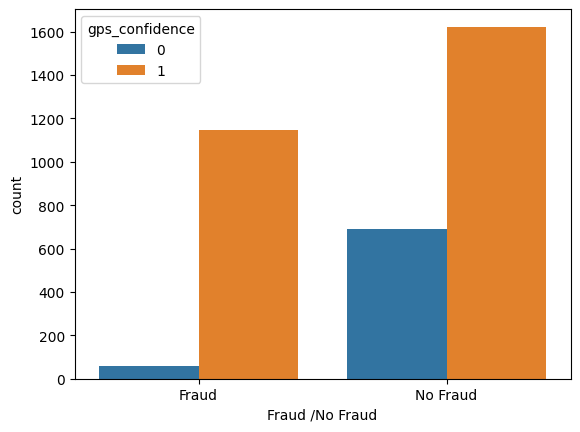

In [ ]:
sns.countplot(data=rh_df_upfront,x='Fraud /No Fraud',hue='gps_confidence')

In [ ]:
rh_df_upfront['change_reason_pricing'].value_counts(normalize=True)*100


No Change                     97.925547
client_destination_changed     2.017619
driver_waypoint_changed        0.056834
Name: change_reason_pricing, dtype: float64

In [ ]:
rh_df_metered

Days=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

px.histogram(rh_df_metered,x='Day_Name',category_orders=dict(Day_Name=Days),color='prediction_price_type')

In [ ]:
from sklearn.preprocessing import LabelEncoder
class_le=LabelEncoder()
rh_df['Payment Type']=class_le.fit_transform(rh_df['Payment Type'].values)

#from sklearn.preprocessing import LabelEncoder
#class_le=LabelEncoder()
#df['Payment Type']=class_le.fit_transform(df['Payment Type'].values)

In [ ]:
rh_df.corr()['Payment Type'].abs().sort_values(ascending=False)

<ipython-input-66-fa20002467b0>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Payment Type             1.000000
%of metered_price        0.572639
eu_indicator             0.260684
dest_change_number       0.223706
distance                 0.157747
upfront_price            0.152180
order_id_new             0.121100
order_try_id_new         0.121098
duration                 0.116570
predicted_duration       0.100420
overpaid_ride_ticket     0.075022
ticket_id_new            0.062369
predicted_distance       0.060261
driver_device_uid_new    0.058697
gps_confidence           0.052156
metered_price            0.015204
Name: Payment Type, dtype: float64

Now we are going to draw a Heat Map. 

<ipython-input-67-293b4310bed6>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

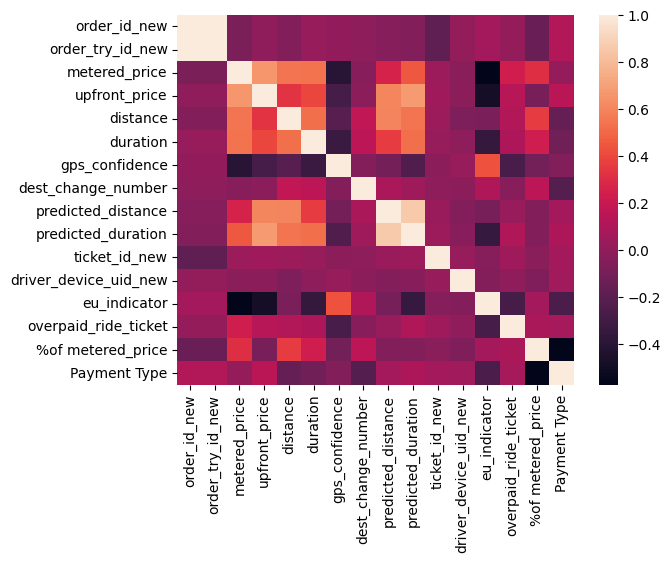

In [ ]:
rh_df_corr=rh_df.corr()
sns.heatmap(rh_df_corr)

In [ ]:
rh_df['Payment Type'].value_counts()

1    3519
0    1404
Name: Payment Type, dtype: int64

Now lwt's Split the Data and Start Modelling it 



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,ConfusionMatrixDisplay
from sklearn import metrics


In [ ]:
train_df,test_df=train_test_split(rh_df,random_state=42,test_size=0.2,)

Now let's take choose the features that are necessary and drop those that have no effect on the data

In [ ]:
#test_df['Payment Type'].value_counts(normalize=True)

In [ ]:
train_df.select_dtypes(include='number').columns

Index(['order_id_new', 'order_try_id_new', 'metered_price', 'upfront_price',
       'distance', 'duration', 'gps_confidence', 'dest_change_number',
       'predicted_distance', 'predicted_duration', 'ticket_id_new',
       'driver_device_uid_new', 'eu_indicator', 'overpaid_ride_ticket',
       '%of metered_price', 'Payment Type'],
      dtype='object')

In [ ]:
del_cols=['order_id_new','order_try_id_new','ticket_id_new','driver_device_uid_new','eu_indicator','%of metered_price']

In [ ]:
train_df=train_df.drop(columns=del_cols)
train_df.select_dtypes(include='number').columns

Index(['metered_price', 'upfront_price', 'distance', 'duration',
       'gps_confidence', 'dest_change_number', 'predicted_distance',
       'predicted_duration', 'overpaid_ride_ticket', 'Payment Type'],
      dtype='object')

In [ ]:
num_cols=train_df.select_dtypes(include='number').columns

In [ ]:
train_df.select_dtypes(exclude="number").columns

Index(['calc_created', 'entered_by', 'b_state', 'prediction_price_type',
       'change_reason_pricing', 'rider_app_version', 'order_try_state',
       'driver_app_version', 'device_name', 'Day_Name', 'Fraud /No Fraud'],
      dtype='object')

In [ ]:
rh_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4923 entries, 0 to 4942
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   order_id_new           4923 non-null   int64         
 1   order_try_id_new       4923 non-null   int64         
 2   calc_created           4923 non-null   datetime64[ns]
 3   metered_price          4923 non-null   float64       
 4   upfront_price          4923 non-null   float64       
 5   distance               4923 non-null   int64         
 6   duration               4923 non-null   int64         
 7   gps_confidence         4923 non-null   int64         
 8   entered_by             4923 non-null   object        
 9   b_state                4923 non-null   object        
 10  dest_change_number     4923 non-null   int64         
 11  prediction_price_type  4923 non-null   object        
 12  predicted_distance     4923 non-null   float64       
 13  pre

In [ ]:
numeric_cols=['metered_price', 'upfront_price', 'distance', 'duration',
              'gps_confidence', 'dest_change_number', 'predicted_distance',
              'predicted_duration', 'overpaid_ride_ticket']

cat_cols=['entered_by', 'b_state','change_reason_pricing', 'order_try_state', 'Fraud /No Fraud']

X=train_df[numeric_cols + cat_cols]
y=train_df['Payment Type']

In [ ]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
metered_price,3938.0,8210.086211,16178.815192,2.000000,5.38,13.87,11243.4600,194483.52
upfront_price,3938.0,8152.708781,19591.651137,1.488095,4.90,11.60,11497.3506,595000.00
distance,3938.0,9888.180295,11285.857911,0.000000,3813.00,7180.50,12020.0000,233190.00
duration,3938.0,1588.521585,1702.653798,0.000000,606.00,1056.00,1936.7500,22402.00
gps_confidence,3938.0,0.797867,0.401642,0.000000,1.00,1.00,1.0000,1.00
dest_change_number,3938.0,1.124429,0.497142,1.000000,1.00,1.00,1.0000,9.00
predicted_distance,3938.0,8929.058405,11305.193246,0.000000,4131.00,6937.50,10664.0000,353538.00
predicted_duration,3938.0,1112.134840,842.760293,0.000000,596.00,934.50,1414.0000,20992.00
overpaid_ride_ticket,3938.0,0.070594,0.256178,0.000000,0.00,0.00,0.0000,1.00


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

Now we will create a pipeline and clear any null and standerdize our data


In [ ]:
X.isna().sum()

metered_price            0
upfront_price            0
distance                 0
duration                 0
gps_confidence           0
dest_change_number       0
predicted_distance       0
predicted_duration       0
overpaid_ride_ticket     0
entered_by               0
b_state                  0
change_reason_pricing    0
order_try_state          0
Fraud /No Fraud          0
dtype: int64

In [ ]:
#for numerical columns

num_pipe=Pipeline([('imputer',SimpleImputer()),('scale',StandardScaler())])

#cat pipe
cat_pipe=Pipeline([('imputer',SimpleImputer(strategy='constant')),('ordinal',OrdinalEncoder())])

#now let's add them together
column_trans=ColumnTransformer([('num',num_pipe,numeric_cols),('cat',cat_pipe,cat_cols)])

In [ ]:
column_trans

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scale', StandardScaler())]),
                                 ['metered_price', 'upfront_price', 'distance',
                                  'duration', 'gps_confidence',
                                  'dest_change_number', 'predicted_distance',
                                  'predicted_duration',
                                  'overpaid_ride_ticket']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['entered_by', 'b_state',
                                  'change_reason_pricing', 'order_try_state',
                                  'Fraud /No Fraud'])])

Models i want to use as my baselines are 

LGR,SVM,RF,Adaptiveboost,Catboost,Gradient boost,XGBOOST

Logistic Regression 

In [ ]:

LG_model=LogisticRegression(random_state=42,n_jobs=-1)
model_01=Pipeline([('column_transform',column_trans),('model',LG_model)])
model_01.fit(X_train,y_train)
y_pred=model_01.predict(X_test)
#model_01.score(X_test,y_test)
metrics.f1_score(y_pred,y_test)

0.921552436003303

In [ ]:
score1=cross_val_score(model_01,X_train,y_train,cv=5,n_jobs=-1,scoring='accuracy')
np.mean(score1)

0.8790476190476191

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.60      0.74       225
           1       0.86      0.99      0.92       563

    accuracy                           0.88       788
   macro avg       0.91      0.80      0.83       788
weighted avg       0.89      0.88      0.87       788



In [ ]:
f1score=f1_score(y_pred,y_test)

In [ ]:
df_model=[]
models=['LogisticRegression','Support Vector','AdaptiveBoost']

LG_model=LogisticRegression(random_state=42,n_jobs=-1)
SVC_model=SVC()
Adaptive_model=AdaBoostClassifier()

for clf,name in zip([LG_model,SVC_model,Adaptive_model],models):
  model=Pipeline([('column_transform',column_trans,),('model',clf)])
  model.fit(X_train,y_train)
  y_pred=model.predict(X_test)
  accuracy=accuracy_score(y_test,y_pred)
  f1_score=metrics.f1_score(y_test,y_pred)
  precision=precision_score(y_test,y_pred)
  recall=recall_score(y_test,y_pred)

  name={'Model':name,
        'Accuracy':accuracy,
        'F1_Score':f1_score,
        'Precision':precision,'Recall':recall}

  df_model.append(name)
  #print(i)


In [ ]:
df_model

[{'Model': 'LogisticRegression',
  'Accuracy': 0.8794416243654822,
  'F1_Score': 0.921552436003303,
  'Precision': 0.8611111111111112,
  'Recall': 0.9911190053285968},
 {'Model': 'Support Vector',
  'Accuracy': 0.9010152284263959,
  'F1_Score': 0.933786078098472,
  'Precision': 0.8943089430894309,
  'Recall': 0.9769094138543517},
 {'Model': 'AdaptiveBoost',
  'Accuracy': 0.8934010152284264,
  'F1_Score': 0.9284497444633731,
  'Precision': 0.8919803600654664,
  'Recall': 0.9680284191829485}]

In [ ]:
DataFrame(df_model)

,Model,Accuracy,F1_Score,Precision,Recall
0,LogisticRegression,0.879442,0.921552,0.861111,0.991119
1,Support Vector,0.901015,0.933786,0.894309,0.976909
2,AdaptiveBoost,0.893401,0.928450,0.891980,0.968028


So we are going to use same but with cross validation

In [ ]:
dict_={}
list_=[]
Model_name=['LogisticRegression','Support Vector','AdaptiveBoost']
LG_model=LogisticRegression(random_state=42,n_jobs=-1)
SVC_model=SVC()
Adaptive_model=AdaBoostClassifier()


scoring=['accuracy','f1','precision','recall']
clf=[LG_model,SVC_model,Adaptive_model]

for md_name,clf_name in zip(Model_name,clf):
  model=Pipeline([('column_transform',column_trans),('model',clf_name)])
  for scorn in scoring:
    scores=cross_val_score(model,X_train,y_train,scoring=scorn)
    scores_=np.mean(scores)
    #print(md_name,scorn,scores_)  
    dict_['Model']=md_name
    dict_[scorn]=scores_
  list_.append(dict_.copy())


In [ ]:
df_1=DataFrame(list_)

In [ ]:
num_pipe2=Pipeline([('imputer',SimpleImputer())])

#cat pipe
cat_pipe2=Pipeline([('imputer',SimpleImputer(strategy='constant')),('ordinal',OrdinalEncoder())])

#now let's add them together
column_trans2=ColumnTransformer([('num',num_pipe2,numeric_cols),('cat',cat_pipe2,cat_cols)])

In [ ]:
dict_2={}
list_2=[]
Model_name2=['Random Forest','Gradient Boost','Xgboost']
Gradient_Boost=GradientBoostingClassifier()
Random_Forest=RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=42)
XGboost=xgb.XGBClassifier(n_estimators=100,learning_rate=0.01,max_depth=4,random_state=1,use_label_encoder=False)


scoring=['accuracy','f1','precision','recall']
clf=[Random_Forest,Gradient_Boost,XGboost]

for md_name,clf_name in zip(Model_name2,clf):
  model=Pipeline([('column_transform',column_trans2),('model',clf_name)])
  for scorn in scoring:
    scores=cross_val_score(model,X_train,y_train,scoring=scorn)
    scores_=np.mean(scores)
    print(md_name,scorn,scores_)  
    dict_2['Model']=md_name
    dict_2[scorn]=scores_
  list_2.append(dict_2.copy())


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



Random Forest accuracy 0.947936507936508
Random Forest f1 0.9640869938584891
Random Forest precision 0.9507953629543252
Random Forest recall 0.9777836905641782
Gradient Boost accuracy 0.9473015873015873
Gradient Boost f1 0.9638900562288845
Gradient Boost precision 0.9442032224861567
Gradient Boost recall 0.9844483863020448


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



Xgboost accuracy 0.8615873015873016


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



Xgboost f1 0.9101569544028827


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



Xgboost precision 0.8486512804917302


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.

/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



Xgboost recall 0.9813372751909337


In [ ]:
df_2=DataFrame(list_2)

In [ ]:
models_used=pd.concat([df_1,df_2])

In [ ]:
models_used=models_used.reset_index(drop=True)

In [ ]:
models_used

,Model,accuracy,f1,precision,recall
0,LogisticRegression,0.879048,0.920692,0.866441,0.982230
1,Support Vector,0.903175,0.935353,0.894277,0.980449
2,AdaptiveBoost,0.907619,0.937371,0.909488,0.967126
3,Random Forest,0.947937,0.964087,0.950795,0.977784
4,Gradient Boost,0.947302,0.963890,0.944203,0.984448
5,Xgboost,0.861587,0.910157,0.848651,0.981337


So our best model is Random Forest

Since it's the best model, we are going to tune this model.

then get the best and Boom deploy

In [ ]:
#num_pipe2=Pipeline([('imputer',SimpleImputer())])

#cat pipe
#cat_pipe2=Pipeline([('imputer',SimpleImputer(strategy='constant')),('ordinal',OrdinalEncoder())])

#now let's add them together
#column_trans2=ColumnTransformer([('num',num_pipe2,numeric_cols),('cat',cat_pipe2,cat_cols)])

In [ ]:
 model=Pipeline([('column_transform',column_trans2),('model',Random_Forest)])
 param_range=np.arange(100,220,20)
 param_grids=[{'model__n_estimators':param_range,'model__criterion':['entropy','gini']}]

 rs=RandomizedSearchCV(estimator=model,param_distributions=param_grids,scoring='accuracy',n_jobs=-1,cv=5,
                       random_state=42,n_iter=10,refit=True
                       )

rs=rs.fit(X_train,y_train)






In [ ]:
print(rs.best_score_)
print(rs.best_estimator_)
print(rs.best_params_)


0.9511111111111111
Pipeline(steps=[('column_transform',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['metered_price',
                                                   'upfront_price', 'distance',
                                                   'duration', 'gps_confidence',
                                                   'dest_change_number',
                                                   'predicted_distance',
                                                   'predicted_duration',
                                                   'overpaid_ride_ticket']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                              

In [ ]:
prf_model=rs.best_estimator_

In [ ]:
DataFrame(prf_model.steps[1][1].feature_importances_)

,0
0,0.197806
1,0.202477
2,0.144137
3,0.157121
4,0.008724
5,0.016924
6,0.110202
7,0.091404
8,0.005859
9,0.013868


In [ ]:
num=prf_model.named_steps['column_transform'].transformers_[0][2]
cat=prf_model.named_steps['column_transform'].transformers_[1][2]
features=num+cat
feat=DataFrame(features)
weight=DataFrame(prf_model.steps[1][1].feature_importances_)
imp_feat_weight=pd.concat([feat,weight],axis=1,keys=['features','weight'],ignore_index=True)

In [ ]:
imp_feat_weight=imp_feat_weight.rename(columns={0:'Feature',1:'Weight'})
imp_feat_weight.sort_values(by='Weight',ascending=False)

,Feature,Weight
1,upfront_price,0.202477
0,metered_price,0.197806
3,duration,0.157121
2,distance,0.144137
6,predicted_distance,0.110202
7,predicted_duration,0.091404
11,change_reason_pricing,0.036553
5,dest_change_number,0.016924
13,Fraud /No Fraud,0.014925
9,entered_by,0.013868


Now let's test this model if it can predict the test data

In [ ]:
numeric_cols=['metered_price', 'upfront_price', 'distance', 'duration',
              'gps_confidence', 'dest_change_number', 'predicted_distance',
              'predicted_duration', 'overpaid_ride_ticket']

cat_cols=['entered_by', 'b_state','change_reason_pricing', 'order_try_state', 'Fraud /No Fraud']

X_valid=test_df[numeric_cols + cat_cols]
y_valid=test_df['Payment Type']

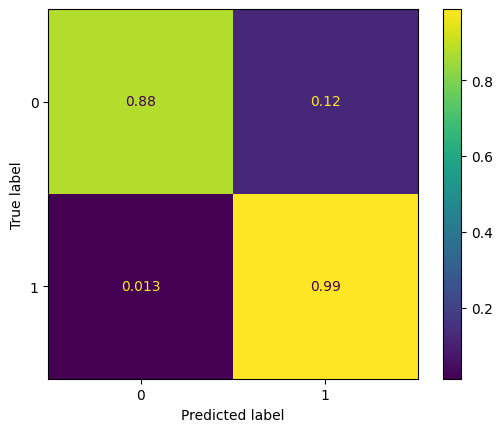

In [ ]:
prf_model.fit(X_train,y_train)
y_pred_final=prf_model.predict(X_valid)
conf_matrix=confusion_matrix(y_valid,y_pred_final,labels=prf_model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=prf_model.classes_)
disp.plot()
#print(conf_matrix)

array([0, 1])

In [ ]:
"""import seaborn as sns
fig,ax=plt.subplots(figsize=(5.5,5.5))
sns.heatmap(conf_matrix,annot=True)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')"""

"import seaborn as sns\nfig,ax=plt.subplots(figsize=(5.5,5.5))\nsns.heatmap(conf_matrix,annot=True)\nplt.xlabel('Predicted Label')\nplt.ylabel('Actual Label')"